### Homework

### Q1. Downloading the data

We'll use [the same NYC taxi dataset](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page), but instead of "Green Taxi Trip Records", we'll use "For-Hire Vehicle Trip Records".

Download the data for January and February 2021.

Note that you need "For-Hire Vehicle Trip Records", not "High Volume For-Hire Vehicle Trip Records".

Read the data for January. How many records are there?

In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [143]:
df_202101 = pd.read_parquet("./data/fhv_tripdata_2021-01.parquet")
df_202102 = pd.read_parquet("./data/fhv_tripdata_2021-02.parquet")

In [144]:
print(f"len data for January : {len(df_202101)}")
print(f"len data for February : {len(df_202102)}")

len data for January : 1154112
len data for February : 1037692


### Q2. Computing duration

Now let's compute the `duration` variable. It should contain the duration of a ride in minutes.

What's the average trip duration in January?

In [145]:
df_202101['duration'] = (df_202101.dropOff_datetime - df_202101.pickup_datetime).astype('timedelta64[m]')
df_202101['duration_s'] = (df_202101.dropOff_datetime - df_202101.pickup_datetime).astype('timedelta64[s]')
df_202101['duration_m'] = df_202101['duration_s']/60

df_202102['duration'] = (df_202102.dropOff_datetime - df_202102.pickup_datetime).astype('timedelta64[m]')
df_202102['duration_s'] = (df_202102.dropOff_datetime - df_202102.pickup_datetime).astype('timedelta64[s]')
df_202102['duration_m'] = df_202102['duration_s']/60

In [146]:
print(f"average duration using function timedelta in minute : {sum(df_202101['duration'])/len(df_202101['duration'])} minutes")
print(f"average duration using function timedelta in second then divide by 60 : {sum(df_202101['duration_m'])/len(df_202101['duration_m'])} minutes")

average duration using function timedelta in minute : 18.733049305440026 minutes
average duration using function timedelta in second then divide by 60 : 19.1672240937939 minutes


In [147]:
print(f"average duration using column duration_m - numpy mean calculation : {np.mean(df_202101['duration_m'])} minutes")

average duration using column duration_m - numpy mean calculation : 19.1672240937939 minutes


### Data preparation

Check the distribution of the duration variable. There are some outliners. 

Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).

How many records did you drop? 

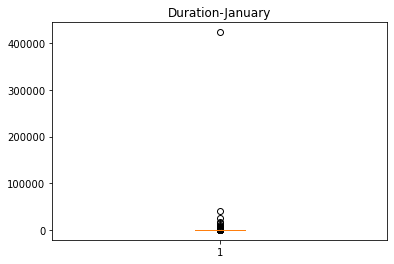

In [148]:
plt.boxplot(df_202101['duration_m'])
plt.title('Duration-January')
plt.show()

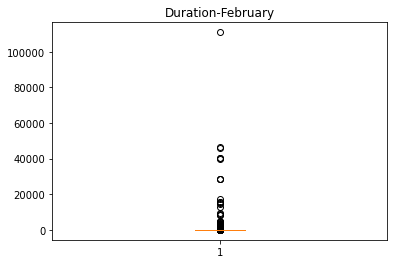

In [149]:
plt.boxplot(df_202102['duration_m'])
plt.title('Duration-February')
plt.show()

In [150]:
# concat January and February dataframe
df_all = pd.DataFrame().append([df_202101, df_202102])

In [151]:
print(f"Total {len(df_all[~df_all['duration_m'].between(1,60)])} outlier records")

Total 91865 outlier records


In [152]:
df_202101_normal = df_202101[df_202101['duration_m'].between(1,60)]

In [166]:
df_202102_normal = df_202102[df_202102['duration_m'].between(1,60)]

### Q3. Missing values

The features we'll use for our model are the pickup and dropoff location IDs. 

But they have a lot of missing values there. Let's replace them with "-1"

What's the factions of missing values for the pickup location ID? (Or the fraction of "-1"s after you filled the NAs)

In [153]:
df_202101_normal['PUlocationID'].fillna(-1, inplace=True)
df_202101_normal['DOlocationID'].fillna(-1, inplace=True)

c:\Users\imamx\anaconda3\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [167]:
df_202102_normal['PUlocationID'].fillna(-1, inplace=True)
df_202102_normal['DOlocationID'].fillna(-1, inplace=True)

c:\Users\imamx\anaconda3\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [155]:
print(f"Fraction of missing values : {len(df_202101_normal[df_202101_normal['PUlocationID']==-1]) / len(df_202101_normal) * 100} %")

Fraction of missing values : 83.52732770722618 %


### Q4. One-hot encoding

Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model. 

* Turn the dataframe into a list of dictionaries
* Fit a dictionary vectorizer 
* Get a feature matrix from it

What's the dimensionality of this matrix? (The number of columns)

In [156]:
categorical = ['PUlocationID', 'DOlocationID']

In [157]:
df_202101_normal[categorical] = df_202101_normal[categorical].astype(str)

c:\Users\imamx\anaconda3\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [168]:
df_202102_normal[categorical] = df_202102_normal[categorical].astype(str)

c:\Users\imamx\anaconda3\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [158]:
train_dicts = df_202101_normal[categorical].to_dict(orient='records')

In [169]:
val_dicts = df_202102_normal[categorical].to_dict(orient='records')

In [159]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [170]:
X_val = dv.transform(val_dicts)

In [160]:
print(f"Dimensionality matrix : {len(dv.feature_names_)} columns")

Dimensionality matrix : 525 columns


### Q5. Training a model

Now let's use the feature matrix from the previous step to train a model. 

* Train a plain linear regression model with default parameters 
* Calculate the RMSE of the model on the training data

What's the RMSE on train?

In [161]:
target = 'duration_m'
y_train = df_202101_normal[target].values

In [171]:
y_val = df_202102_normal[target].values

In [162]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [163]:
y_pred = lr.predict(X_train)

In [165]:
print(f"RMSE on train : {mean_squared_error(y_train, y_pred, squared=False)}")

RMSE on train : 10.528519107211306


### Q6. Evaluating the model

Now let's apply this model to the validation dataset (Feb 2021). 

What's the RMSE on validation?

In [172]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

11.01428319227392

In [174]:
print(f"RMSE on validation : {mean_squared_error(y_val, y_pred, squared=False)}")

RMSE on validation : 11.01428319227392
